# Notebook 04: Volatile Product Recovery

This notebook is part of the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

This notebook simulates the fermentation of acetogenic growth in a large scale bubble column reactor at two given temperatures, using mass balances as defined in notebook 01, and a thermodynaminc-based black box model of acetogenic growth, building on notebook 02.

Notebook author: Philip J. Gorter de Vries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

## Bubble column setup:

In [2]:
R = 8.314
TR, PR = 272.95, 9290 #http://www.ddbst.com/en/EED/PCP/VAP_C4.php

#Temperature range:
T0 = 273.15
dt = 80

T = np.arange(T0, T0+dt+1, 1)

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

#Reactor
v_gas = 0.5 # average gas velocity [m/s]
h_r = 30 # height of the reactor [m]
ar = 5 # aspect ratio: height to diameter
r = h_r/(ar * 2)
h = 2/3 * h_r # initial height of broth  assuming it is 2/3 filled [m]
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h #reactor volume [m^3]
F_G = v_gas * A
Gas_holdup = 0.6*(v_gas)**0.7 #from Stephanie's paper
V_G = V_L*Gas_holdup

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

# Define vapor pressure as functions of temperature

<p> Antoine equation: </p>
<div style="text-align: center">  $ log_{10}(P_T/P_0) = A_1 - A_2/(T + A_3) $
    <span style="float:right;">(eq. 12)</span>
</div>
<br>
<div style="text-align: center">  $ P(T) = 10^{A_1 - A_2/(T + A_3)} * P_0 $
    <span style="float:right;">(eq. 13)</span>
</div>

<p> Clausius-Clapeyron equation: </p>
<div style="text-align: center">  $ P(T) = e^{\Delta _{vap}H/RT + C} $
    <span style="float:right;">(eq. 14)</span>
</div>

<p> Clausius-Clapeyron approximation: </p>
<div style="text-align: center">  $ \Delta T /\Delta P = RT_b^2/(P_0*\Delta H_{vap})$
    <span style="float:right;">(eq. 15)</span>
</div>
<br>
<div style="text-align: center">  $ P(T) = RT_b^2/(P_0*\Delta H_{vap}) * T + C$
    <span style="float:right;">(eq. 16)</span>
</div>

The Clausius-Clapeyron equation is used based on comparison in notebook S01.

To find the constant C, a reference temperature and pressure are needed

<div style="text-align: center">  $ C = log_{10}(P_0) +\Delta H_{vap}/RT_0 $
    <span style="float:right;">(eq. 11b)</span>
</div>
<br>
<div style="text-align: center">  $ P_T = e^{\Delta H_{vap}/RT + log_{10}(P_0) +\Delta H_{vap}/RT_0} $
    <span style="float:right;">(eq. 11c)</span>
</div>

In [3]:
DGR = pd.read_csv("../Data/PhaseChangeData.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"DGR": float})["DGR"]
DH_vapR = pd.read_csv("../Data/PhaseChangeData.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"DH_vap": float})["DH_vap"]
PR = pd.read_csv("../Data/PhaseChangeData.csv", encoding= 'unicode_escape', header=0, index_col="Compound", dtype = {"P0": float})["P0"]

TR_PP = 293.15 # [K]

def Pt(P0, T0, DH_vap, t, x):
    C = np.log(P0) + DH_vap/(R*T0) #Calculate the constant C, the intersection with the y-axis
    return np.exp(-DH_vap/(R*t) + C) * x

## Pressure with Depth
Pascal's law

<div style="text-align: center">  $ P(h) = \rho * g *h + P_0 $ [$Pa$]
    <span style="float:right;">(eq. 18)</span>
</div>

In [4]:
def p_height(h):
    """
    This function calculates the pressure excerted by the column of water at a given depth
    """
    return 1000*9.81*h + P0

P0 = 101325
h = np.arange(0, 31, 1)

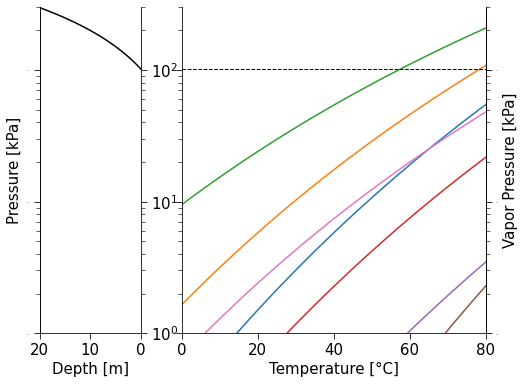

In [5]:
plt.rcParams['axes.spines.top'] = False

#Output results for publication
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8, 6), gridspec_kw={'width_ratios': [1, 3]})
ax1.axis([20, 0, 0.1, 400])
ax2.axis([Kelvin_Celsius(T0), Kelvin_Celsius(T0)+dt, 1000/1000, 300000/1000])
plt.subplots_adjust(wspace=0.20)
ax1.yaxis.tick_right()

plt.rcParams['axes.spines.top'] = False

#ax1.set_title("C", fontdict = {'fontsize': 20}, loc = "left")
#ax1.set_title("Pressure by depth [Pa]")
ax1.plot(h,p_height(h)/1000, color = 'black')
ax1.set_xlabel('Depth [m]', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=15, length = 6)
ax1.tick_params(axis='both', which='minor', labelsize=15, length = 4)
ax1.yaxis.tick_right()
ax_l = ax1.secondary_yaxis('left')
ax_l.tick_params(axis='y', which='major', labelsize=0, length = 6)
ax_l.tick_params(axis='y', which='minor', labelsize=0, length = 4)
ax_l.set_ylabel('Pressure [kPa]', fontsize=15)

#ax2.set_title("Vapor pressure of pure VOCs by Temperature [Pa]")
ax2.plot(Kelvin_Celsius(T), Pt(PR["Actt"], TR_PP, DH_vapR["Actt"], T, 1)/1000)
#ax2.plot(Kelvin_Celsius(T), Pt(PR["MetOH"], TR_PP, DH_vapR["MetOH"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["EtOH"], TR_PP, DH_vapR["EtOH"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], T, 1)/1000)
#ax2.plot(Kelvin_Celsius(T), Pt(PR["PropOH"], TR_PP, DH_vapR["PropOH"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["ButOH"], TR_PP, DH_vapR["ButOH"], T, 1)/1000)
#ax2.plot(Kelvin_Celsius(T), Pt(PR["Butnon"], TR_PP, DH_vapR["Butnon"], T, 1)/1000)
ax2.plot(Kelvin_Celsius(T), Pt(PR["Butyrt"], TR_PP, DH_vapR["Butyrt"], T, 1)/1000) #stays below 10000 Pa
ax2.plot(Kelvin_Celsius(T), Pt(PR["Butdiol"], TR_PP, DH_vapR["Butdiol"], T, 1)/1000) #stays below 10000 Pa
ax2.plot(Kelvin_Celsius(T), Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1)/1000)
ax2.axhline(y = 101325/1000, color = 'black', linestyle = '--', linewidth = 1)
ax2.set_xlabel('Temperature [°C]', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15, length = 6)
ax2.tick_params(axis='both', which='minor', labelsize=15, length = 4)
ax_r = ax2.secondary_yaxis('right')#, fontsize=0)
ax_r.tick_params(axis='y', which='major', labelsize=0, length = 6)
ax_r.tick_params(axis='y', which='minor', labelsize=0, length = 4)
ax_r.set_ylabel('Vapor Pressure [kPa]', fontsize=15)
plt.yscale("log")

# Add arrows to demonstrate how the graph is read:
T_demo_C = 60
T_demo = Celsius_Kelvin(T_demo_C)
Inter_Demo_VP = Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], T_demo, 1)/1000
#ax2.arrow(x=T_demo_C, y=0, dx=0, dy=Inter_Demo_VP, length_includes_head=True, head_width=2, head_length=10, width=0.1, facecolor='black', edgecolor='black')
#ax2.arrow(x=T_demo_C, y=Inter_Demo_VP, dx=-T_demo_C, dy=0, head_width=0, head_length=0, width=1.2, facecolor='black', edgecolor='black')#, width=.08, facecolor='black', edgecolor='black')
Inter_Demo_D = (Inter_Demo_VP - P0/1000)/9.810
#ax1.arrow(x=0, y=Inter_Demo_VP, dx=Inter_Demo_D, dy=0, length_includes_head=True, head_width=7, head_length=0.6, width=1.200, facecolor='black', edgecolor='black')#, width=.08, facecolor='black', edgecolor='black')
#ax1.arrow(x=Inter_Demo_D, y=Inter_Demo_VP, dx=0, dy=(10000/1000-Inter_Demo_VP), length_includes_head=True, head_width=1, head_length=.500, width=0.1, facecolor='black', edgecolor='black')#, width=.08, facecolor='black', edgecolor='black')

#ax2.legend(["Acetate","Ethanol","Acetone","Butanol","Butyrate","Butanediol","Water"],loc='center right', bbox_to_anchor=(1.5, 0.5))

#plt.savefig('../Figures/F04C_ProductVaporPres.png')
plt.show()

## Concentration effect

<p> Raoult's law </p>
<div style="text-align: center">  $ P_i = P^*_i * x_i $ [$Pa$]
    <span style="float:right;">(eq. 17)</span>
</div>

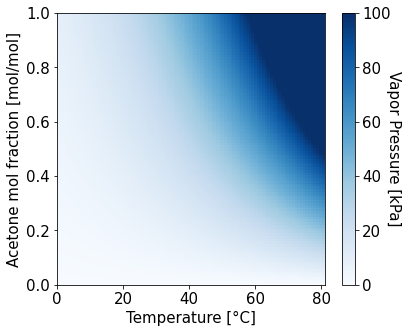

In [6]:
plt.rcParams['axes.spines.top'] = True

# generate two 2D grids for the x & y bounds
t, x = np.meshgrid(np.linspace(T0, T0+dt+1, 100), np.linspace(0, 1, 100))

#Calculate the constant C, the intersection with the y-axis
C = np.log(PR["Actn"]) + DH_vapR["Actn"]/(R*TR_PP)

z = np.exp(-DH_vapR["Actn"]/(R*t) + C) * x

# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
z = z[:-1, :-1]/1000
z_min, z_max = 0, 100000/1000 #-np.abs(z).max(), np.abs(z).max()

#fig = plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(6,5))

c = ax.pcolormesh(Kelvin_Celsius(t), x, z, cmap='Blues', vmin=z_min, vmax=z_max)
#plt.title("D", fontdict = {'fontsize': 20}, loc = "left")
plt.xlabel('Temperature [°C]', fontsize=15)
plt.ylabel('Acetone mol fraction [mol/mol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax.axis([Kelvin_Celsius(t.min()), Kelvin_Celsius(t.max()),x.min(), x.max()])
cbar = fig.colorbar(c, ax=ax)
cbar.ax.tick_params(axis='both', which='major', labelsize=15)
cbar.set_label("Vapor Pressure [kPa]", fontdict = {'fontsize': 15}, rotation=270, labelpad=10)

plt.savefig('../Figures/F04D_AcetoneVaporPres.png')
plt.show()

At a biologically reasonable concentration of product, what is the ratio of VOC to water in the off-gas?

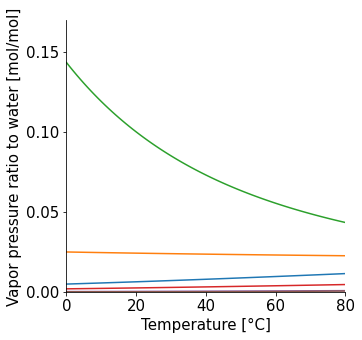

at 30c: 8.5 %
at 60c: 5.5 %


In [7]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

#fig, axs = plt.subplots(nrows = 1, ncols = 2, constrained_layout=False, figsize=(10,5))

x = 0.01

#plt.title(f"Mol fraction of VOC in the gas, for {round(x*100)}% or {round(x*c_H2O/1000,1)}M in broth")
#plt.subplot(1,2,1)
plt.figure(figsize=(5,5))
#plt.title("E", fontdict = {'fontsize': 20}, loc = "left")
plt.plot(Kelvin_Celsius(T), Pt(PR["Actt"], TR_PP, DH_vapR["Actt"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["EtOH"], TR_PP, DH_vapR["EtOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
#plt.plot(Kelvin_Celsius(T), Pt(PR["MetOH"], TR_PP, DH_vapR["MetOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
#plt.plot(Kelvin_Celsius(T), Pt(PR["PropOH"], TR_PP, DH_vapR["PropOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["ButOH"], TR_PP, DH_vapR["ButOH"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
#plt.plot(Kelvin_Celsius(T), Pt(PR["Butnon"], TR_PP, DH_vapR["Butnon"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["Butyrt"], TR_PP, DH_vapR["Butyrt"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["Butdiol"], TR_PP, DH_vapR["Butdiol"], T, x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.plot(Kelvin_Celsius(T), Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], T, 1))
plt.axis([Kelvin_Celsius(T0), Kelvin_Celsius(T0)+dt, 0, 0.17])
#plt.legend(["Acetone","Acetate","Methanol","Ethanol","Propanol","Butanol","Butanone","Water","Butyrate","Butanediol"], fontsize=15,bbox_to_anchor=(1.1, 0.9), loc='upper left', borderaxespad=0.)

plt.xlabel('Temperature [°C]', fontsize=15)
plt.yticks([0,0.05,0.1,0.15])
#plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylabel('Vapor pressure ratio to water [mol/mol]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

#plt.subplot(1,2,2)
#plt.axis('off')

#plt.savefig('../Figures/F04E_Legend.svg')
plt.show()

print("at 30c:",round(Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], Celsius_Kelvin(30), x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], Celsius_Kelvin(30), 1)*100,1),"%")
print("at 60c:",round(Pt(PR["Actn"], TR_PP, DH_vapR["Actn"], Celsius_Kelvin(60), x)/Pt(PR["H2O"], TR_PP, DH_vapR["H2O"], Celsius_Kelvin(60), 1)*100,1),"%")


# Equilibirium product concentration

Assuming:
    - steady state, dcp/dt = 0, meaning the production rate equals the removal rate
    - water and product reach saturation concentration in the gas flow of the column (based on vapor pressure)
    - Ideal gas law
    - stoichiometric conversion of H2 to product based on overall reaction balancing CO2 and H2 as substrate and the compound of interest and water as products. No biomass.
    - no product inhibition, H2 limited
    - 9:1 molar feed ratio H2:CO2

In [8]:
#Yields = pd.DataFrame({'Compound': ["Acetate", "Ethanol", "Acetone", "Butyrate", "Butanol", "Butanediol"],
Yields = pd.DataFrame({'Formula': ["C2H4O2", "C2H6O", "C3H6O", "C4H7O2", "C4H10O", "C4H10O2"],
                       'MolarWeight': [60, 46, 58, 88, 74, 90],
                       'Cmol': [2, 2, 3, 4, 4, 4],
                       'DegRed': [8, 12, 16, 20, 24, 22]}, 
                       index = ["Actt", "EtOH", "Actn", "Butyrt", "ButOH", "Butdiol"])

Yields['Y_PS'] = 1/(Yields.DegRed/2) #H2 is the only source of reducing equivalents and has a degree of reduction of 2, therefore the yield is the product's degree of reduction divided by 2
Yields

,Formula,MolarWeight,Cmol,DegRed,Y_PS
Actt,C2H4O2,60,2,8,0.250000
EtOH,C2H6O,46,2,12,0.166667
Actn,C3H6O,58,3,16,0.125000
Butyrt,C4H7O2,88,4,20,0.100000
ButOH,C4H10O,74,4,24,0.083333
Butdiol,C4H10O2,90,4,22,0.090909


In [9]:
# Load Henry's Law values
DR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["DR"]
HR = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["HR"]
kh = pd.read_csv("../Data/HenrysLawData.csv", index_col = "Compound")["k"]
theta = 1.022 # temperature correction factor

def KLa(C,T):
    return 0.32 * (DR[C]/DR["O2"])**0.5 * v_gas**0.7 * theta**(T-293.15) #[1/s]

def Csat(C, T, y):
    return HR[C] * math.e**(kh[C]*(1/T-1/298.15)) * 10**(-5) * p_m * y

def RT(C,T,c,y):
    return KLa(C,T) * (Csat(C,T, y) - c)

Product removal rate

In [10]:
R_PRemoval = Yields.Y_PS.loc["Actt"] * RT("H2",Celsius_Kelvin(30),0,0.9)
R_PRemoval #[mol/m3/h]

0.11145920637894254

molar concentration of the product in the off-gas

In [11]:
c_PG = R_PRemoval/(F_G/V_G)
c_PG  #[mol/m3]

1.6466685509915178

Partial pressure of the product in the off-gas

In [12]:
P_PG = c_PG * R * Celsius_Kelvin(30)
P_PG

4150.245467231815

Molar concentration in the broth

In [13]:
x_PL = P_PG/Pt(PR["Actt"], TR_PP, DH_vapR["Actt"], Celsius_Kelvin(30), 1)
x_PL #[molP/molW]

1.376193979501587

Define it as a function and plot:

In [14]:
def x_PL(C,T,c,y):
    P0 = PR[C]
    T0 = TR_PP, 
    DH_vap = DH_vapR[C]
    x = 1
    R_PRemoval = Yields.Y_PS.loc[C] * RT("H2",T,c,y) #[mol/m3/h] # RT = KLa(C,T) * (Csat(C,T, y) - c)
    P_PG = R_PRemoval/(F_G/V_G) * R * T
    return P_PG/Pt(PR[C], TR_PP, DH_vapR[C], T, 1) #[1/s]

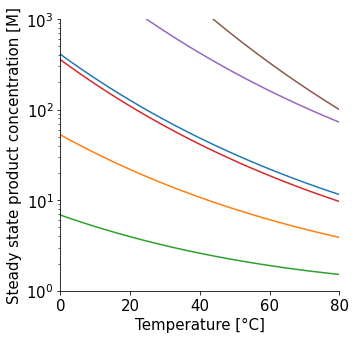

In [18]:
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

plt.figure(figsize=(5,5))
plt.plot(Kelvin_Celsius(T), x_PL("Actt", T, 0, 0.9)/0.018)
plt.plot(Kelvin_Celsius(T), x_PL("EtOH", T, 0, 0.9)/0.018)
plt.plot(Kelvin_Celsius(T), x_PL("Actn", T, 0, 0.9)/0.018)
plt.plot(Kelvin_Celsius(T), x_PL("ButOH", T, 0, 0.9)/0.018)
plt.plot(Kelvin_Celsius(T), x_PL("Butyrt", T, 0, 0.9)/0.018)
plt.plot(Kelvin_Celsius(T), x_PL("Butdiol", T, 0, 0.9)/0.018)
plt.axis([Kelvin_Celsius(T0), Kelvin_Celsius(T0)+dt, 1, 1000])
plt.yscale("log")
plt.xlabel('Temperature [°C]', fontsize=15)
#plt.yticks([0,0.05,0.1,0.15])
plt.ylabel('Steady state product concentration [M]', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [16]:
x_PL("EtOH", Celsius_Kelvin(60), 0, 0.9)/0.018*46,x_PL("Actn", Celsius_Kelvin(60), 0, 0.9)/0.018*58

(280.20263614582836, 110.09338070071959)

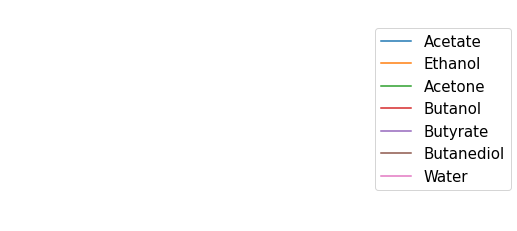

In [17]:
plt.plot(np.NaN, np.NaN)
plt.plot(np.NaN, np.NaN)
plt.plot(np.NaN, np.NaN)
plt.plot(np.NaN, np.NaN)
plt.plot(np.NaN, np.NaN)
plt.plot(np.NaN, np.NaN)
plt.plot(np.NaN, np.NaN)
plt.legend(["Acetate","Ethanol","Acetone","Butanol","Butyrate","Butanediol","Water"], fontsize=15,bbox_to_anchor=(1.1, 0.9), loc='upper left', borderaxespad=0.)

plt.axis('off')

plt.savefig('../Figures/Figure4/E_Legend.svg')
plt.show()